In [1]:
import sys
sys.path.append('../scripts/')
from puddle_world import *
import itertools 
import collections 
from copy import copy

In [2]:
class PolicyEvaluator: 
    def __init__(self, widths, goal, puddles, time_interval, sampling_num, \
                 puddle_coef=10.0, lowerleft=np.array([-4, -4]).T, upperright=np.array([4, 4]).T):  #puddle_coef追加
        self.pose_min = np.r_[lowerleft, 0]
        self.pose_max = np.r_[upperright, math.pi*2]
        self.widths = widths
        self.goal = goal
        
        self.index_nums = ((self.pose_max - self.pose_min)/self.widths).astype(int)
        nx, ny, nt = self.index_nums
        self.indexes = list(itertools.product(range(nx), range(ny), range(nt)))
        
        self.value_function, self.final_state_flags =  self.init_value_function() 
        self.policy = self.init_policy()
        self.actions = set([tuple(self.policy[i]) for i in self.indexes]) 
        
        self.state_transition_probs = self.init_state_transition_probs(time_interval, sampling_num)
        self.depths = self.depth_means(puddles, sampling_num)
        
        self.time_interval = time_interval
        self.puddle_coef = puddle_coef
        
    def policy_evaluation_sweep(self):   ###policyevaluator7
        max_delta = 0.0
        for index in self.indexes:
            if not self.final_state_flags[index]:
                q = self.action_value(tuple(self.policy[index]), index)
                
                delta = abs(self.value_function[index] - q)
                max_delta = delta if delta > max_delta else max_delta
                
                self.value_function[index] = q
            
        return max_delta
    
    def action_value(self, action, index):
        value = 0.0
        for delta, prob in self.state_transition_probs[(action, index[2])]:  #index[2]: 方角のインデックス
            after = tuple(self.edge_correction(np.array(index).T + delta) ) #indexに差分deltaを足してはみ出し処理の後にタプルにする
            reward = - self.time_interval * self.depths[(after[0], after[1])] * self.puddle_coef - self.time_interval
            value += (self.value_function[after] + reward) * prob

        return value
            
    def edge_correction(self, index):
        index[2] = (index[2] + self.index_nums[2])%self.index_nums[2] #方角の処理
                
        return index
        
    def depth_means(self, puddles, sampling_num):
        ###セルの中の座標を均等にsampling_num**2点サンプリング###
        dx = np.linspace(0, self.widths[0], sampling_num) 
        dy = np.linspace(0, self.widths[1], sampling_num)
        samples = list(itertools.product(dx, dy))
        
        tmp = np.zeros(self.index_nums[0:2]) #深さの合計が計算されて入る
        for xy in itertools.product(range(self.index_nums[0]), range(self.index_nums[1])):
            for s in samples:
                pose = self.pose_min + self.widths*np.array([xy[0], xy[1], 0]).T + np.array([s[0], s[1], 0]).T #セルの中心の座標
                for p in puddles:
                    tmp[xy] += p.depth*p.inside(pose) #深さに水たまりの中か否か（1 or 0）をかけて足す
                        
            tmp[xy] /= sampling_num**2 #深さの合計から平均値に変換
                       
        return tmp
    
    def init_state_transition_probs(self, time_interval, sampling_num):
        ###セルの中の座標を均等にsampling_num**3点サンプリング###
        dx = np.linspace(0.001, self.widths[0]*0.999, sampling_num) #隣のセルにはみ出さないように端を避ける
        dy = np.linspace(0.001, self.widths[1]*0.999, sampling_num)
        dt = np.linspace(0.001, self.widths[2]*0.999, sampling_num)
        samples = list(itertools.product(dx, dy, dt))
        
        ###各行動、各方角でサンプリングした点を移動してインデックスの増分を記録###
        tmp = {}
        for a in self.actions:
            for i_t in range(self.index_nums[2]):
                transitions = []
                for s in samples:
                    before = np.array([s[0], s[1], s[2] + i_t*self.widths[2]]).T + self.pose_min  #遷移前の姿勢
                    before_index = np.array([0, 0, i_t]).T                                                      #遷移前のインデックス
                
                    after = IdealRobot.state_transition(a[0], a[1], time_interval, before)   #遷移後の姿勢
                    after_index = np.floor((after - self.pose_min)/self.widths).astype(int)   #遷移後のインデックス
                    
                    transitions.append(after_index - before_index)                                  #インデックスの差分を追加
                    
                unique, count = np.unique(transitions, axis=0, return_counts=True)   #集計（どのセルへの遷移が何回か）
                probs = [c/sampling_num**3 for c in count]                   #サンプル数で割って確率にする
                tmp[a,i_t] = list(zip(unique, probs))
                
        return tmp
        
    def init_policy(self):
        tmp = np.zeros(np.r_[self.index_nums,2]) #制御出力が2次元なので、配列の次元を4次元に
        for index in self.indexes:
            center = self.pose_min + self.widths*(np.array(index).T + 0.5)  #セルの中心の座標
            tmp[index] = PuddleIgnoreAgent.policy(center, self.goal)
            
        return tmp
        
    def init_value_function(self): 
        v = np.empty(self.index_nums) #全離散状態を要素に持つ配列を作成
        f = np.zeros(self.index_nums) 
        
        for index in self.indexes:
            f[index] = self.final_state(np.array(index).T)
            v[index] = self.goal.value if f[index] else -100.0
                
        return v, f
        
    def final_state(self, index):
        x_min, y_min, _ = self.pose_min + self.widths*index          #xy平面で左下の座標
        x_max, y_max, _ = self.pose_min + self.widths*(index + 1) #右上の座標（斜め上の離散状態の左下の座標）
        
        corners = [[x_min, y_min, _], [x_min, y_max, _], [x_max, y_min, _], [x_max, y_max, _] ] #4隅の座標
        return sum([self.goal.inside(np.array(c).T) for c in corners ]) == 4 #全部goal.insideがTrueならsumが4に

In [3]:
import seaborn as sns   

puddles = [Puddle((-2, 0), (0, 2), 0.1), Puddle((-0.5, -2), (2.5, 1), 0.1)] 
pe = PolicyEvaluator(np.array([0.2, 0.2, math.pi/18]).T, Goal(-3,-3), puddles, 0.1, 10)

counter = 0 #スイープの回数

1 9.911547
2 8.08655607
3 6.6666968397
4 5.57598908199
5 5.25741498952
6 5.10369283329
7 4.8065059694
8 4.45340582442
9 4.3245141011
10 4.25522020224
11 4.10425214649
12 3.90483378936
13 3.85195911305
14 3.80068146945
15 3.69526453399
16 3.55274433211
17 3.54451588012
18 3.49724861877
19 3.4106664414
20 3.32697327759
21 3.31744278487
22 3.27017734675
23 3.19279331573
24 3.15574088916
25 3.13674798275
26 3.08837279984
27 3.01612208057
28 3.01203930191
29 2.9860013332
30 2.93636795312
31 2.89618518045
32 2.8875358148
33 2.8561787319
34 2.80545607359
35 2.79373838714
36 2.77723369427
37 2.74182849126
38 2.70481612977
39 2.70045183274
40 2.67790626477
41 2.63940691215
42 2.62630873378
43 2.61459384171
44 2.5873431336
45 2.55501801658
46 2.55245535751
47 2.53490656314
48 2.50395755128
49 2.49183376434
50 2.48266815064
51 2.46044161911
52 2.43292684103
53 2.43101907827
54 2.41646906204
55 2.39046261721
56 2.38022434174
57 2.37243715502
58 2.35346260239
59 2.33045968837
60 2.32863710601
61 2.

451 0.339290958283
452 0.333048658501
453 0.327489049931
454 0.32214709625
455 0.316831778654
456 0.311544992211
457 0.306288565649
458 0.301064261468
459 0.295873776139
460 0.290718740358
461 0.285600719376
462 0.280521213387
463 0.275481657986
464 0.270483424672
465 0.265527821425
466 0.260616093322
467 0.255749423213
468 0.250928932439
469 0.246155681607
470 0.241430671393
471 0.236754843399
472 0.232129081044
473 0.227554210489
474 0.223031001598
475 0.218560168932
476 0.214142372764
477 0.209778220132
478 0.205468265906
479 0.201213013883
480 0.197012917901
481 0.192868382966
482 0.1887797664
483 0.184747379005
484 0.180771486228
485 0.176852309343
486 0.172990026645
487 0.169184774639
488 0.165436649244
489 0.161745706989
490 0.158111966222
491 0.154535408309
492 0.151015978832
493 0.147553588791
494 0.144148115791
495 0.140799405229
496 0.137507271472
497 0.134271499026
498 0.131091843697
499 0.127968033737
500 0.124899770983
501 0.121886731978
502 0.118928569085
503 0.116024911

<IPython.core.display.Javascript object>


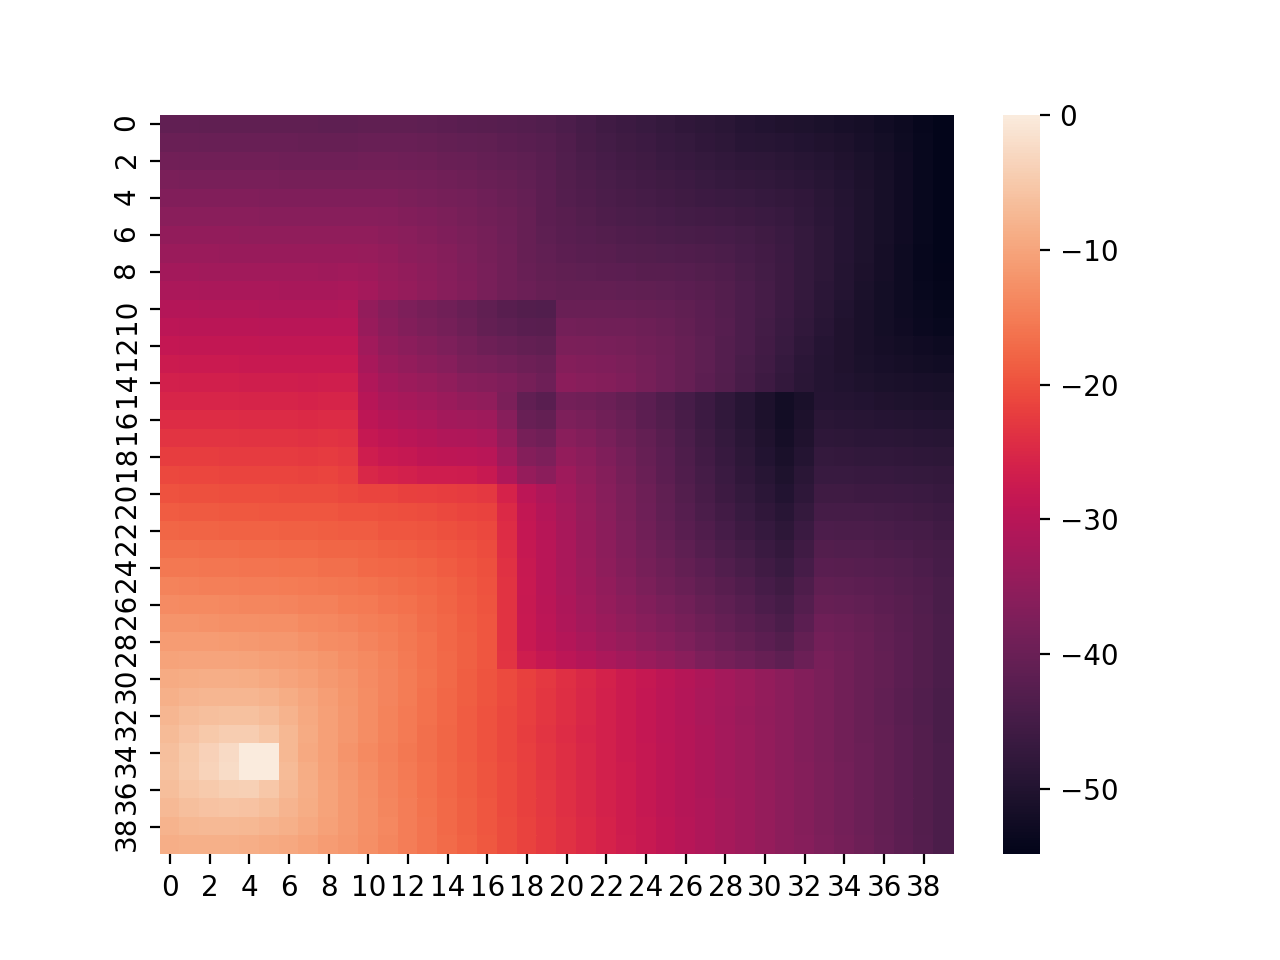

In [4]:
delta = 1e100

while delta > 0.01:  ###policyevaluator7exec
    delta = pe.policy_evaluation_sweep()
    counter += 1
    print(counter, delta)

v = pe.value_function[:, :, 0]
sns.heatmap(np.rot90(v), square=False)
plt.show()